# Formal Concept Analysis Algorithm

## User Guide

### First of all
Run blocks from 1 to 8 sequentially.

### Quick Start
Create a formal context defining which object has which property, e.g. from a simple ASCII-art style cross-table with object rows and property columns or from dict using **fromstring** or **fromdict**.

To query common properties of objects or common objects of properties (derivation) use **intension** and  **extension**.

Get the closest matching objects-properties pair of objects or properties (formal concepts) with **your_context[list of objects or properties]**

Make a Graphviz visualization of the lattice - use .graphviz(view=True) to directly render it and display the resulting PDF.

### See also

The implementation is based on these Python packages:
- bitsets – Ordered subsets over a predefined domain
- graphviz – Simple Python interface for Graphviz


In [1]:
import io
import typing
import operator
import fractions
import functools
import heapq
import bitsets
import graphviz

from itertools import permutations, groupby, starmap

In [2]:
class lazyproperty:
    """Non-data descriptor caching the computed result as instance attribute.
    >>> class Spam(object):
    ...     @lazyproperty
    ...     def eggs(self):
    ...         return 'spamspamspam'
    >>> spam=Spam(); spam.eggs
    'spamspamspam'
    >>> spam.eggs='eggseggseggs'; spam.eggs
    'eggseggseggs'
    >>> Spam().eggs
    'spamspamspam'
    >>> Spam.eggs  # doctest: +ELLIPSIS
    <...lazyproperty object at 0x...>
    """

    def __init__(self, fget):
        self.fget = fget
        for attr in ('__module__', '__name__', '__doc__'):
            setattr(self, attr, getattr(fget, attr))

    def __get__(self, instance, owner):
        if instance is None:
            return self
        result = instance.__dict__[self.__name__] = self.fget(instance)
        return result

In [3]:
Vector = bitsets.bases.MemberBits
"""Single row or column of a boolean matrix as bit vector."""


class Vectors(bitsets.series.Tuple):
    """Paired collection of rows or columns of a boolean matrix relation.
    Trailing zeros see https://stackoverflow.com/q/63917579/3456664
    """

    def _pair_with(self, relation, index, other):
        if hasattr(self, 'prime'):
            raise RuntimeError(f'{self!r} attempt _pair_with {other!r}')

        self.relation = relation
        self.relation_index = index

        Prime = other.BitSet.supremum
        Double = self.BitSet.supremum

        make_prime = other.BitSet.fromint
        make_double = self.BitSet.fromint

        def prime(bitset):
            """FCA derivation operator (extent->intent, intent->extent)."""
            prime = Prime

            i = 0
            while bitset:
                shift = (bitset & -bitset).bit_length() - 1  # trailing zero(s)
                if not shift:
                    shift = 1
                    prime &= other[i]
                i += shift
                bitset >>= shift

            return make_prime(prime)

        def double(bitset):
            """FCA double derivation operator (extent->extent, intent->intent)."""
            prime = Prime

            i = 0
            while bitset:
                shift = (bitset & -bitset).bit_length() - 1
                if not shift:
                    shift = 1
                    prime &= other[i]
                i += shift
                bitset >>= shift

            double = Double

            i = 0
            while prime:
                shift = (prime & -prime).bit_length() - 1
                if not shift:
                    shift = 1
                    double &= self[i]
                i += shift
                prime >>= shift

            return make_double(double)

        def doubleprime(bitset):
            """FCA single and double derivation (extent->extent+intent, intent->intent+extent)."""
            prime = Prime

            i = 0
            while bitset:
                shift = (bitset & -bitset).bit_length() - 1
                if not shift:
                    shift = 1
                    prime &= other[i]
                i += shift
                bitset >>= shift

            bitset = prime
            double = Double

            i = 0
            while bitset:
                shift = (bitset & -bitset).bit_length() - 1
                if not shift:
                    shift = 1
                    double &= self[i]
                i += shift
                bitset >>= shift

            return make_double(double), make_prime(prime)

        self.prime = self.BitSet.prime = prime
        self.double = self.BitSet.double = double
        self.doubleprime = self.BitSet.doubleprime = doubleprime

    def __reduce__(self):
        return self.relation, (self.relation_index,)


class Relation(tuple):
    """Binary relation as interconnected pair of bitset collections.
    >>> br = Relation('Condition', 'Symbol',
    ... ('TT', 'TF', 'FT', 'FF'), ('->', '<-'),
    ... [(True, False, True, True), (True, True, False, True)])
    >>> br
    <Relation(ConditionVectors('1011', '1101'), SymbolVectors('11', '01', '10', '11'))>
    >>> br[1].BitSet.frommembers(('->', '<-')).prime().members()
    ('TT', 'FF')
    """

    __slots__ = ()

    def __new__(cls, xname, yname, xmembers, ymembers, xbools, _ids=None):
        if _ids is not None:
            xid, yid = _ids
            X = bitsets.meta.bitset(xname, xmembers, xid, Vector, None, Vectors)
            Y = bitsets.meta.bitset(yname, ymembers, yid, Vector, None, Vectors)
        else:
            X = bitsets.bitset(xname, xmembers, Vector, tuple=Vectors)
            Y = bitsets.bitset(yname, ymembers, Vector, tuple=Vectors)

        x = X.Tuple.frombools(xbools)
        y = Y.Tuple.frombools(zip(*x.bools()))

        self = super().__new__(cls, (x, y))

        x._pair_with(self, 0, y)
        y._pair_with(self, 1, x)

        return self

    __call__ = tuple.__getitem__

    def __repr__(self):
        return f'<{self.__class__.__name__}({self[0]!r}, {self[1]!r})>'

    def __reduce__(self):
        X, Y = (v.BitSet for v in self)
        return (self.__class__,
                (X.__name__, Y.__name__,
                 X._members, Y._members,
                 self[0].bools(),
                 (X._id, Y._id)))

In [4]:
class Concept():
    """Formal concept as pair of extent and intent.
    Example:
        >>> lattice = Context.fromstring(EXAMPLE).lattice
        >>> concept = lattice['+1',]
        >>> concept
        <Concept {1sg, 1pl} <-> [+1 -2 -3] <=> +1>
        >>> concept.index, concept.dindex
        (7, 6)
        >>> concept.objects, concept.properties
        ((), ('+1',))
        >>> concept.atoms  # doctest: +NORMALIZE_WHITESPACE
        (<Atom {1sg} <-> [+1 -2 -3 +sg -pl] <=> 1sg>,
         <Atom {1pl} <-> [+1 -2 -3 +pl -sg] <=> 1pl>)
        >>> concept.upper_neighbors  # doctest: +NORMALIZE_WHITESPACE
        (<Concept {1sg, 1pl, 2sg, 2pl} <-> [-3] <=> -3>,
         <Concept {1sg, 1pl, 3sg, 3pl} <-> [-2] <=> -2>)
        >>> concept.lower_neighbors  # doctest: +NORMALIZE_WHITESPACE
        (<Atom {1sg} <-> [+1 -2 -3 +sg -pl] <=> 1sg>,
         <Atom {1pl} <-> [+1 -2 -3 +pl -sg] <=> 1pl>)
    """
    objects = ()

    properties = ()

    def __init__(self, lattice, extent, intent, upper, lower) -> None:
        self.lattice = lattice
        self._extent = extent
        self._intent = intent
        self.upper_neighbors = upper
        self.lower_neighbors = lower
 
    def _eq(self, other):
        if not isinstance(other, Concept):
            return NotImplemented

        if (other._extent.members() != self._extent.members()
            or other._intent.members() != self._intent.members()):
            return False

        for attname in ('upper_neighbors', 'lower_neighbors'):
            s_neighbors = getattr(self, attname)
            o_neighbors = getattr(other, attname)
            if len(o_neighbors) != len(s_neighbors):
                return False
            for s, o in zip(s_neighbors, o_neighbors):
                if o._extent.members() != s._extent.members():
                    return False
        return True

    def __iter__(self):
        """Yield ``extent`` and ``intent`` (e.g. for pair unpacking).
        Example:
            >>> lattice = Context.fromstring(EXAMPLE).lattice
            >>> extent, intent = lattice['+1',]
            >>> print(extent, intent)
            ('1sg', '1pl') ('+1', '-2', '-3')
        """
        yield self._extent.members()
        yield self._intent.members()

    @property
    def extent(self) -> typing.Tuple[str, ...]:
        """The objects subsumed by the concept.
        Example:
            >>> lattice = Context.fromstring(EXAMPLE).lattice
            >>> lattice['+1',].extent
            ('1sg', '1pl')
        """
        return self._extent.members()

    @property
    def intent(self) -> typing.Tuple[str, ...]:
        """The properties implied by the concept."
        Example:
            >>> lattice = Context.fromstring(EXAMPLE).lattice
            >>> lattice['+1',].intent
            ('+1', '-2', '-3')
        """
        return self._intent.members()

    def __str__(self) -> str:
        """
        Example:
            >>> lattice = Context.fromstring(EXAMPLE).lattice
            >>> print(lattice['+1',])
            {1sg, 1pl} <-> [+1 -2 -3] <=> +1
        """
        extent = ', '.join(self._extent.members())
        intent = ' '.join(self._intent.members())
        objects = ' <=> {}'.format(' '.join(self.objects)) if self.objects else ''
        properties = ' <=> {}'.format(' '.join(self.properties)) if self.properties else ''
        return f'{{{extent}}} <-> [{intent}]{objects}{properties}'

    def __repr__(self) -> str:
        """
        Example:
            >>> lattice = Context.fromstring(EXAMPLE).lattice
            >>> lattice['+1',]
            <Concept {1sg, 1pl} <-> [+1 -2 -3] <=> +1>
        """
        return f'<{self.__class__.__name__} {self}>'

    def upset(self, _sortkey=operator.attrgetter('index'),
              _next_concepts=operator.attrgetter('upper_neighbors')):
        """Yield implied concepts including ``self``.
        Yields:
            :class:`.Concept` instances.
        Example:
            >>> lattice = Context.fromstring(EXAMPLE).lattice
            >>> list(lattice['+1',].upset())  # doctest: +NORMALIZE_WHITESPACE
            [<Concept {1sg, 1pl} <-> [+1 -2 -3] <=> +1>,
             <Concept {1sg, 1pl, 2sg, 2pl} <-> [-3] <=> -3>,
             <Concept {1sg, 1pl, 3sg, 3pl} <-> [-2] <=> -2>,
             <Supremum {1sg, 1pl, 2sg, 2pl, 3sg, 3pl} <-> []>]
        """
        heap = [(_sortkey(c), c) for c in [self]]
        heapq.heapify(heap)

        push = functools.partial(heapq.heappush, heap)
        pop = functools.partial(heapq.heappop, heap)

        seen = -1

        while heap:
            index, concept = pop()
            if index > seen:
                seen = index
                yield concept
                for c in _next_concepts(concept):
                    push((_sortkey(c), c))

    def downset(self,
                _sortkey=operator.attrgetter('dindex'),
                _next_concepts=operator.attrgetter('lower_neighbors')):
        """Yield subsumed concepts including ``self``.
        Yields:
            :class:`.Concept` instances.
        Example:
            >>> lattice = Context.fromstring(EXAMPLE).lattice
            >>> list(lattice['+1',].downset())  # doctest: +NORMALIZE_WHITESPACE
            [<Concept {1sg, 1pl} <-> [+1 -2 -3] <=> +1>,
             <Atom {1sg} <-> [+1 -2 -3 +sg -pl] <=> 1sg>,
             <Atom {1pl} <-> [+1 -2 -3 +pl -sg] <=> 1pl>,
             <Infimum {} <-> [+1 -1 +2 -2 +3 -3 +sg +pl -sg -pl]>]
        """
        heap = [(_sortkey(c), c) for c in [self]]
        heapq.heapify(heap)

        push = functools.partial(heapq.heappush, heap)
        pop = functools.partial(heapq.heappop, heap)

        seen = -1

        while heap:
            index, concept = pop()
            if index > seen:
                seen = index
                yield concept
                for c in _next_concepts(concept):
                    push((_sortkey(c), c))

    def implies(self, other: 'Concept') -> bool:
        """Implication comparison.
        Args:
            other: :class:`.Concept` instance from the same lattice.
        Returns:
            bool: ``True`` if ``self`` implies ``other`` else ``False``.
        Example:
            >>> lattice = Context.fromstring(EXAMPLE).lattice
            >>> lattice['+1',] <= lattice['-3',] <= lattice['-3',] <= lattice[()]
            True
            >>> lattice['+1',] <= lattice['+sg',] or lattice['+sg',] <= lattice['+1',]
            False
        """
        return self._extent & other._extent == self._extent

    __le__ = implies

    def subsumes(self, other: 'Concept') -> bool:
        """Subsumption comparison.
        Args:
            other: :class:`.Concept` instance from the same lattice.
        Returns:
            bool: ``True`` if ``self`` subsumes ``other`` else ``False``.
        Example:
            >>> lattice = Context.fromstring(EXAMPLE).lattice
            >>> lattice['+1',] >= lattice['+1', '+sg'] >= lattice['+1', '+sg'] >= lattice['+1', '-1']
            True
            >>> lattice['+1',] >= lattice['+sg',] or lattice['+sg',] >= lattice['+1',]
            False
        """
        return self._extent | other._extent == self._extent

    __ge__ = subsumes

    def properly_implies(self, other: 'Concept') -> bool:
        """Proper implication comparison.
        Args:
            other: :class:`.Concept` instance from the same lattice.
        Returns:
            bool: ``True`` if ``self`` properly implies ``other`` else ``False``.
        Example:
            >>> lattice = Context.fromstring(EXAMPLE).lattice
            >>> lattice['+1',] < lattice['-3',] < lattice[()]
            True
        """
        return self._extent & other._extent == self._extent != other._extent

    __lt__ = properly_implies

    def properly_subsumes(self, other: 'Concept') -> bool:
        """Proper subsumption comparison.
        Args:
            other: :class:`.Concept` instance from the same lattice.
        Returns:
            bool: ``True`` if ``self`` properly subsumes ``other`` else ``False``.
        Example:
            >>> lattice = Context.fromstring(EXAMPLE).lattice
            >>> lattice['+1',] > lattice['+1', '+sg'] > lattice['+1', '-1']
            True
        """
        return self._extent | other._extent == self._extent != other._extent

    __gt__ = properly_subsumes

    def join(self, other: 'Concept') -> 'Concept':
        """Least upper bound, supremum, or, generalization.
        Args:
            other: :class:`.Concept` instance from the same lattice.
        Returns:
            :class:`.Concept` instance from the same lattice.
        Example:
            >>> lattice = Context.fromstring(EXAMPLE).lattice
            >>> lattice['+1',].join(lattice['+2',])
            <Concept {1sg, 1pl, 2sg, 2pl} <-> [-3] <=> -3>
            >>> lattice['+2',] | lattice['+1',]
            <Concept {1sg, 1pl, 2sg, 2pl} <-> [-3] <=> -3>
        """
        common = self._extent | other._extent
        extent = self.lattice._context._extents.double(common)
        return self.lattice._mapping[extent]

    __or__ = join

    def meet(self, other: 'Concept') -> 'Concept':
        """Greatest lower bound, infimum, and, unification.
        Args:
            other: :class:`.Concept` instance from the same lattice.
        Returns:
            :class:`.Concept` instance from the same lattice.
        Example:
            >>> lattice = Context.fromstring(EXAMPLE).lattice
            >>> lattice['-1', '-2'].meet(lattice['-pl',])
            <Atom {3sg} <-> [-1 -2 +3 +sg -pl] <=> 3sg>
            >>> lattice['-pl',] & lattice['-1', '-2']
            <Atom {3sg} <-> [-1 -2 +3 +sg -pl] <=> 3sg>
        """
        common = self._extent & other._extent
        extent = self.lattice._context._extents.double(common)
        return self.lattice._mapping[extent]

    __and__ = meet

    def incompatible_with(self, other: 'Concept') -> bool:
        """Infimum meet comparison.
        Args:
            other: :class:`.Concept` instance from the same lattice.
        Returns:
            bool: ``True`` if ``self`` is incompatible with ``other`` else ``False``.
        Example:
            >>> lattice = Context.fromstring(EXAMPLE).lattice
            >>> lattice['+1',].incompatible_with(lattice['+3',])
            True
            >>> lattice['+1',].incompatible_with(lattice['+sg',])
            False
        """
        return not self._extent & other._extent

    def complement_of(self, other: 'Concept') -> bool:
        """Infimum meet and supremum join comparison.
        Args:
            other: :class:`.Concept` instance from the same lattice.
        Returns:
            bool: ``True`` if ``self`` is the complement of ``other`` else ``False``.
        Example:
            >>> lattice = Context.fromstring(EXAMPLE).lattice
            >>> lattice['+1',].complement_of(lattice['-1',])
            True
            >>> lattice['+1',].complement_of(lattice['+3',])
            False
        """
        return (not self._extent & other._extent 
                and (self._extent | other._extent) == self.lattice.supremum._extent)

    def subcontrary_with(self, other: 'Concept') -> bool:
        """Non-infimum meet and supremum join comparison.
        Args:
            other: :class:`.Concept` instance from the same lattice.
        Returns:
            bool: ``True`` if ``self`` is the subcontrary to ``other`` else ``False``.
        Example:
            >>> lattice = Context.fromstring(EXAMPLE).lattice
            >>> lattice['-1',].subcontrary_with(lattice['-3',])
            True
            >>> lattice['-1',].subcontrary_with(lattice['+sg',])
            False
        """
        return (self._extent & other._extent
                and (self._extent | other._extent) == self.lattice.supremum._extent)

    def orthogonal_to(self, other: 'Concept') -> bool:
        """Non-infimum meet, incomparable, and non-supremum join comparison.
        Args:
            other: :class:`.Concept` instance from the same lattice.
        Returns:
            bool: ``True`` if ``self`` is orthogonal to ``other`` else ``False``.
        Example:
            >>> lattice = Context.fromstring(EXAMPLE).lattice
            >>> lattice['+1',].orthogonal_to(lattice['+sg',])
            True
            >>> lattice['+1',].orthogonal_to(lattice['+3',])
            False
        """
        meet = self._extent & other._extent
        return (not not meet and meet != self._extent and meet != other._extent
                and (self._extent | other._extent) != self.lattice.supremum._extent)

    def minimal(self) -> typing.Tuple[str, ...]:
        """Shortlex minimal properties generating the concept.
        Returns:
            Property name strings.
        Example:
            >>> lattice = Context.fromstring(EXAMPLE).lattice
            >>> lattice['+1',].minimal()
            ('+1',)
        Note:
            For :class:`.Infimum`, this returns **all** properties instead of
            the first contradictory subset of properties.
        """
        return self.lattice._context._minimal(self._extent, self._intent).members()

    def attributes(self) -> typing.Iterator[typing.Tuple[str]]:
        """Yield properties generating the concept in shortlex order.
        Yields:
            Tuples of property name strings.
        Example:
            >>> lattice = Context.fromstring(EXAMPLE).lattice
            >>> list(lattice['+1',].attributes())
            [('+1',), ('+1', '-2'), ('+1', '-3'), ('-2', '-3'), ('+1', '-2', '-3')]
        """
        minimize = self.lattice._context._minimize(self._extent, self._intent)
        return (i.members() for i in minimize)


class Infimum(Concept):
    """Contradiction with empty ``extent`` and universal ``intent``.
    Example:
        >>> lattice = Context.fromstring(EXAMPLE).lattice
        >>> lattice.infimum
        <Infimum {} <-> [+1 -1 +2 -2 +3 -3 +sg +pl -sg -pl]>
        >>> lattice.infimum.index, lattice.infimum.dindex
        (0, 21)
        >>> lattice.infimum.objects, lattice.infimum.properties
        ((), ())
        >>> lattice.infimum.atoms
        ()
        >>> lattice.infimum.upper_neighbors  # doctest: +NORMALIZE_WHITESPACE
        (<Atom {1sg} <-> [+1 -2 -3 +sg -pl] <=> 1sg>,
         <Atom {1pl} <-> [+1 -2 -3 +pl -sg] <=> 1pl>,
         <Atom {2sg} <-> [-1 +2 -3 +sg -pl] <=> 2sg>,
         <Atom {2pl} <-> [-1 +2 -3 +pl -sg] <=> 2pl>,
         <Atom {3sg} <-> [-1 -2 +3 +sg -pl] <=> 3sg>,
         <Atom {3pl} <-> [-1 -2 +3 +pl -sg] <=> 3pl>)
        >>> lattice.infimum.lower_neighbors
        ()
    """

    def minimal(self) -> typing.Tuple[str, ...]:
        """Shortlex minimal properties generating the concept.
        Returns:
            Property name strings.
        Example:
            >>> lattice = Context.fromstring(EXAMPLE).lattice
            >>> lattice.infimum.minimal()
            ('+1', '-1', '+2', '-2', '+3', '-3', '+sg', '+pl', '-sg', '-pl')
        Note:
            For :class:`.Infimum`, this returns **all** properties instead of
            the first contradictory subset of properties.
        """
        return self._intent.members()


class Atom(Concept):
    """Concept which is a minimal non-zero element in its lattice.
    Example:
        >>> lattice = Context.fromstring(EXAMPLE).lattice
        >>> lattice.atoms  # doctest: +NORMALIZE_WHITESPACE
        (<Atom {1sg} <-> [+1 -2 -3 +sg -pl] <=> 1sg>,
         <Atom {1pl} <-> [+1 -2 -3 +pl -sg] <=> 1pl>,
         <Atom {2sg} <-> [-1 +2 -3 +sg -pl] <=> 2sg>,
         <Atom {2pl} <-> [-1 +2 -3 +pl -sg] <=> 2pl>,
         <Atom {3sg} <-> [-1 -2 +3 +sg -pl] <=> 3sg>,
         <Atom {3pl} <-> [-1 -2 +3 +pl -sg] <=> 3pl>)
        >>> lattice.atoms[0].index, lattice.atoms[0].dindex
        (1, 15)
        >>> lattice.atoms[0].objects, lattice.atoms[0].properties
        (('1sg',), ())
        >>> lattice.atoms[0].atoms
        (<Atom {1sg} <-> [+1 -2 -3 +sg -pl] <=> 1sg>,)
        >>> lattice.atoms[0].upper_neighbors  # doctest: +NORMALIZE_WHITESPACE
        (<Concept {1sg, 1pl} <-> [+1 -2 -3] <=> +1>,
         <Concept {1sg, 2sg} <-> [-3 +sg -pl]>,
         <Concept {1sg, 3sg} <-> [-2 +sg -pl]>)
        >>> lattice.atoms[0].lower_neighbors  # doctest: +NORMALIZE_WHITESPACE
        (<Infimum {} <-> [+1 -1 +2 -2 +3 -3 +sg +pl -sg -pl]>,)
    """


class Supremum(Concept):
    """Tautology with universal ``extent`` and empty ``intent``.
    Example:
        >>> lattice = Context.fromstring(EXAMPLE).lattice
        >>> lattice.supremum
        <Supremum {1sg, 1pl, 2sg, 2pl, 3sg, 3pl} <-> []>
        >>> lattice.supremum.index, lattice.supremum.dindex
        (21, 0)
        >>> lattice.supremum.objects, lattice.supremum.properties
        ((), ())
        >>> lattice.supremum.atoms  # doctest: +NORMALIZE_WHITESPACE
        (<Atom {1sg} <-> [+1 -2 -3 +sg -pl] <=> 1sg>,
         <Atom {1pl} <-> [+1 -2 -3 +pl -sg] <=> 1pl>,
         <Atom {2sg} <-> [-1 +2 -3 +sg -pl] <=> 2sg>,
         <Atom {2pl} <-> [-1 +2 -3 +pl -sg] <=> 2pl>,
         <Atom {3sg} <-> [-1 -2 +3 +sg -pl] <=> 3sg>,
         <Atom {3pl} <-> [-1 -2 +3 +pl -sg] <=> 3pl>)
        >>> lattice.supremum.upper_neighbors
        ()
        >>> lattice.supremum.lower_neighbors  # doctest: +NORMALIZE_WHITESPACE
        (<Concept {1sg, 1pl, 2sg, 2pl} <-> [-3] <=> -3>,
         <Concept {1sg, 1pl, 3sg, 3pl} <-> [-2] <=> -2>,
         <Concept {2sg, 2pl, 3sg, 3pl} <-> [-1] <=> -1>,
         <Concept {1sg, 2sg, 3sg} <-> [+sg -pl] <=> +sg -pl>,
         <Concept {1pl, 2pl, 3pl} <-> [+pl -sg] <=> +pl -sg>)
    """

In [5]:
class Lattice():
    """Formal concept lattice as directed acyclic graph of concepts.
    Example:
        >>> lattice = Context.fromstring(EXAMPLE).lattice
        >>> lattice
        <Lattice object of 6 atoms 22 concepts 5 coatoms at 0x...>
    """
    
    @staticmethod
    def _longlex(concept):
        return concept._extent.longlex()

    @staticmethod
    def _shortlex(concept):
        return concept._extent.shortlex()

    @classmethod
    def _fromlist(cls, context, lattice, unordered) -> 'Lattice':
        make_objects = context._Objects.fromint
        make_properties = context._Properties.fromint
        inst = object.__new__(cls)
        concepts = [Concept(inst,
                            make_objects(sum(1 << e for e in ex)),
                            make_properties(sum(1 << i for i in in_)),
                            up, lo)
                    for ex, in_, up, lo in lattice]

        if unordered:
            index_map = dict(enumerate(concepts))
            shortlex = inst._shortlex
            longlex = inst._longlex
            concepts.sort(key=shortlex)
            for index, c in enumerate(concepts):
                c.index = index
                upper = (index_map[i] for i in c.upper_neighbors)
                lower = (index_map[i] for i in c.lower_neighbors)
                c.upper_neighbors = tuple(sorted(upper, key=shortlex))
                c.lower_neighbors = tuple(sorted(lower, key=longlex))
        else:
            for index, c in enumerate(concepts):
                c.index = index
                c.upper_neighbors = tuple(concepts[i] for i in c.upper_neighbors)
                c.lower_neighbors = tuple(concepts[i] for i in c.lower_neighbors)

        cls._init(inst, context, concepts)
        return inst

    def __init__(self, context: 'Context', infimum=()) -> None:
        """Create lattice from context."""
        concepts = [Concept(self, *args)
                    for args in context._lattice(infimum)]
        mapping = self._make_mapping(concepts)

        shortlex = self._shortlex
        longlex = self._longlex
        for index, c in enumerate(concepts):
            c.index = index
            upper = (mapping[u] for u in c.upper_neighbors)
            lower = (mapping[l] for l in c.lower_neighbors)
            c.upper_neighbors = tuple(sorted(upper, key=shortlex))
            c.lower_neighbors = tuple(sorted(lower, key=longlex))

        self._init(self, context, concepts, mapping=mapping)

    @staticmethod
    def _make_mapping(concepts):
        return {c._extent: c for c in concepts}

    @staticmethod
    def _init(inst,
              context: 'Context',
              concepts,
              mapping=None, unpickle=False) -> None:
        inst._context = context
        inst._concepts = concepts

        if mapping is None:
            mapping = inst._make_mapping(inst._concepts)
        inst._mapping = mapping

        if unpickle:
            return

        atoms = inst.atoms
        for dindex, c in enumerate(sorted(inst._concepts, key=inst._longlex)):
            c.dindex = dindex
            e = c._extent
            c.atoms = tuple(a for a in atoms if e | a._extent == e)

        inst._annotate(inst._context, inst._mapping)

        for a in inst.atoms:
            a.__class__ = Atom
        inst.supremum.__class__ = Supremum
        inst.infimum.__class__ = Infimum

    @staticmethod
    def _annotate(context, mapping):
        """Annotate object/attribute concepts with their objects/properties."""
        touched = set()
        for o in context.objects:
            extent = context.extension(context.intension([o]), raw=True)
            c = mapping[extent]
            if c.objects:
                c.objects.append(o)
            else:
                c.objects = [o]
                touched.add(c)

        for c in touched:
            c.objects = tuple(c.objects)

        touched = set()
        for p in context.properties:
            extent = context.extension([p], raw=True)
            c = mapping[extent]
            if c.properties:
                c.properties.append(p)
            else:
                c.properties = [p]
                touched.add(c)

        for c in touched:
            c.properties = tuple(c.properties)

    def __getstate__(self):
        """Pickle lattice as ``(context, concepts)`` tuple."""
        return self._context, self._concepts

    def __setstate__(self, state):
        """Unpickle lattice from ``(context, concepts)`` tuple."""
        context, concepts = state
        self._init(self, context, concepts, unpickle=True)

    def _tolist(self):
        return [(tuple(c._extent.iter_set()),
                 tuple(c._intent.iter_set()),
                 tuple(u.index for u in c.upper_neighbors),
                 tuple(l.index for l in c.lower_neighbors))
                for c in self._concepts]

    def _eq(self, other) -> typing.Union[type(NotImplemented), bool]:
        """Return ``True`` if two lattices are equivalent.
        Note:
            Does not compares their context objects.
            Lattice-equivalence comparison is present mainly for unit-tests
            (not meant to be efficient). Context-comparison should be superior
            in most cases.
        """
        if not isinstance(other, Lattice):
            return NotImplemented

        if (len(other._concepts) != len(self._concepts)
            or not all(s._eq(o) for s, o in zip(self._concepts, other._concepts))):
            return False

        if (len(other._mapping) != len(self._mapping)
            or {e.members() for e in other._mapping}
            != {e.members() for e in self._mapping}):
            return False

        for s, o in zip(self._concepts, other._concepts):
            if (o.index != s.index or o.dindex != s.dindex
                or [a._extent.members() for a in o.atoms]
                != [a._extent.members() for a in s.atoms]
                or o.objects != s.objects or o.properties != s.properties):
                return False

        return True
    
    def __str__(self) -> str:
        """Return the full string representation of the lattice.
        Example:
            >>> lattice = Context.fromstring(EXAMPLE).lattice
            >>> print(lattice)  # doctest: +ELLIPSIS
            <Lattice object of 6 atoms 22 concepts 5 coatoms at 0x...>
                {} <-> [+1 -1 +2 -2 +3 -3 +sg +pl -sg -pl]
                {1sg} <-> [+1 -2 -3 +sg -pl] <=> 1sg
                {1pl} <-> [+1 -2 -3 +pl -sg] <=> 1pl
                {2sg} <-> [-1 +2 -3 +sg -pl] <=> 2sg
                {2pl} <-> [-1 +2 -3 +pl -sg] <=> 2pl
                {3sg} <-> [-1 -2 +3 +sg -pl] <=> 3sg
                {3pl} <-> [-1 -2 +3 +pl -sg] <=> 3pl
                {1sg, 1pl} <-> [+1 -2 -3] <=> +1
                {1sg, 2sg} <-> [-3 +sg -pl]
                {1sg, 3sg} <-> [-2 +sg -pl]
                {1pl, 2pl} <-> [-3 +pl -sg]
                {1pl, 3pl} <-> [-2 +pl -sg]
                {2sg, 2pl} <-> [-1 +2 -3] <=> +2
                {2sg, 3sg} <-> [-1 +sg -pl]
                {2pl, 3pl} <-> [-1 +pl -sg]
                {3sg, 3pl} <-> [-1 -2 +3] <=> +3
                {1sg, 2sg, 3sg} <-> [+sg -pl] <=> +sg -pl
                {1pl, 2pl, 3pl} <-> [+pl -sg] <=> +pl -sg
                {1sg, 1pl, 2sg, 2pl} <-> [-3] <=> -3
                {1sg, 1pl, 3sg, 3pl} <-> [-2] <=> -2
                {2sg, 2pl, 3sg, 3pl} <-> [-1] <=> -1
                {1sg, 1pl, 2sg, 2pl, 3sg, 3pl} <-> []
        """
        concepts = '\n'.join(f'    {c}' for c in self._concepts)
        return f'{self!r}\n{concepts}'

    def __repr__(self) -> str:
        """Return the debug string representation of the lattice.
        Example:
            >>> lattice = 
            Context.fromstring('''
            ...    |+1|-1|+2|-2|+3|-3|+sg|+du|+pl|-sg|-du|-pl|
            ... 1s | X|  |  | X|  | X|  X|   |   |   |  X|  X|
            ... 1de| X|  |  | X|  | X|   |  X|   |  X|   |  X|
            ... 1pe| X|  |  | X|  | X|   |   |  X|  X|  X|   |
            ... 1di| X|  | X|  |  | X|   |  X|   |  X|   |  X|
            ... 1pi| X|  | X|  |  | X|   |   |  X|  X|  X|   |
            ... 2s |  | X| X|  |  | X|  X|   |   |   |  X|  X|
            ... 2d |  | X| X|  |  | X|   |  X|   |  X|   |  X|
            ... 2p |  | X| X|  |  | X|   |   |  X|  X|  X|   |
            ... 3s |  | X|  | X| X|  |  X|   |   |   |  X|  X|
            ... 3d |  | X|  | X| X|  |   |  X|   |  X|   |  X|
            ... 3p |  | X|  | X| X|  |   |   |  X|  X|  X|   |
            ... ''').lattice
            >>> lattice  # doctest: +ELLIPSIS
            <Lattice object of 11 atoms 65 concepts 6 coatoms at 0x...>
        """
        return (f'<{self.__class__.__name__} object'
                f' of {len(self.atoms)} atoms'
                f' {len(self)} concepts'
                f' {len(self.supremum.lower_neighbors)} coatoms'
                f' at {id(self):#x}>')

    def __call__(self, properties: typing.Tuple[str]) -> Concept:
        """Return concept having all given ``properties`` as intension.
        Args:
            properties: Tuple of property names.
        Returns:
            :class:`.Concept` instance from this lattice.
        Example:
            >>> lattice = Context.fromstring(EXAMPLE).lattice
            >>> lattice(['+1', '-sg'])
            <Atom {1pl} <-> [+1 -2 -3 +pl -sg] <=> 1pl>
        """
        extent = self._context.extension(properties, raw=True)
        return self._mapping[extent]

    def __getitem__(self, key: typing.Union[int, typing.Tuple[str, ...]]) -> Concept:
        """Return concept by index, intension, or extension.
        Args:
            key: Integer index, properties tuple, or objects tuple.
        Returns:
            :class:`.Concept` instance from this lattice.
        Example:
            >>> lattice = Context.fromstring(EXAMPLE).lattice
            >>> lattice[1:3]  # doctest: +NORMALIZE_WHITESPACE
            [<Atom {1sg} <-> [+1 -2 -3 +sg -pl] <=> 1sg>,
             <Atom {1pl} <-> [+1 -2 -3 +pl -sg] <=> 1pl>]
            >>> lattice['-1', '-sg']
            <Concept {2pl, 3pl} <-> [-1 +pl -sg]>
            >>> lattice['1sg', '1pl', '2pl']
            <Concept {1sg, 1pl, 2sg, 2pl} <-> [-3] <=> -3>
        """
        if isinstance(key, (int, slice)):
            return self._concepts[key]

        if not key:
            return self.supremum

        extent, intent = self._context.__getitem__(key, raw=True)
        return self._mapping[extent]

    def __iter__(self) -> typing.Iterator[Concept]:
        """Yield all concepts of the lattice.
        Yields:
            All :class:`.Concept` instances from this lattice.
        Example:
            >>> lattice = Context.fromstring(EXAMPLE).lattice
            >>> iterconcepts = iter(lattice)
            >>> next(iterconcepts)
            <Infimum {} <-> [+1 -1 +2 -2 +3 -3 +sg +pl -sg -pl]>
            >>> next(iterconcepts)
            <Atom {1sg} <-> [+1 -2 -3 +sg -pl] <=> 1sg>
        """
        return iter(self._concepts)

    def __len__(self) -> int:
        """Return the number of concepts in the lattice.
        Returns:
            Number of lattice concepts.
        Example:
            >>> lattice = Context.fromstring(EXAMPLE).lattice
            >>> len(lattice)
            22
        """
        return len(self._concepts)

    def join(self, concepts: typing.Iterable[Concept]) -> Concept:
        """Return the nearest concept that subsumes all given concepts.
        Args:
            concepts: :class:`.Concept` instances from this lattice.
        Returns:
            :class:`.Concept` instance from this lattice.
        Example:
            >>> lattice = Context.fromstring(EXAMPLE).lattice
            >>> lattice.join([])
            <Infimum {} <-> [+1 -1 +2 -2 +3 -3 +sg +pl -sg -pl]>
            >>> lattice.join([lattice['1sg',], lattice['1pl',], lattice['2sg',]])
            <Concept {1sg, 1pl, 2sg, 2pl} <-> [-3] <=> -3>
        """
        extents = (c._extent for c in concepts)
        join = self._context._Objects.reduce_or(extents)
        return self._mapping[join.double()]

    def meet(self, concepts: typing.Iterable[Concept]) -> Concept:
        """Return the nearest concept that implies all given concepts.
        Args:
            concepts: :class:`.Concept` instances from this lattice.
        Returns:
            :class:`.Concept` instance from this lattice.
        Example:
            >>> lattice = Context.fromstring(EXAMPLE).lattice
            >>> lattice.meet([])
            <Supremum {1sg, 1pl, 2sg, 2pl, 3sg, 3pl} <-> []>
            >>> lattice.meet([lattice['-1',], lattice['-2',], lattice['-pl',]])
            <Atom {3sg} <-> [-1 -2 +3 +sg -pl] <=> 3sg>
        """
        extents = (c._extent for c in concepts)
        meet = self._context._Objects.reduce_and(extents)
        return self._mapping[meet.double()]

    def upset_union(self, concepts: typing.Iterable[Concept], _sortkey=operator.attrgetter('index'),
                    _next_concepts=operator.attrgetter('upper_neighbors')) -> typing.Iterator[Concept]:
        """Yield all concepts that subsume any of the given ones.
        Args:
            concepts: :class:`.Concept` instances from this lattice.
        Yields:
            :class:`.Concept` instances from this lattice.
        Example:
            >>> lattice = Context.fromstring(EXAMPLE).lattice
            >>> list(lattice.upset_union([lattice['+1',], lattice['+2',]]))  # doctest: +NORMALIZE_WHITESPACE
            [<Concept {1sg, 1pl} <-> [+1 -2 -3] <=> +1>,
             <Concept {2sg, 2pl} <-> [-1 +2 -3] <=> +2>,
             <Concept {1sg, 1pl, 2sg, 2pl} <-> [-3] <=> -3>,
             <Concept {1sg, 1pl, 3sg, 3pl} <-> [-2] <=> -2>,
             <Concept {2sg, 2pl, 3sg, 3pl} <-> [-1] <=> -1>,
             <Supremum {1sg, 1pl, 2sg, 2pl, 3sg, 3pl} <-> []>]
        """
        concepts = set(concepts)
        if len(concepts) < 2:
            return iter(concepts)
        concepts = (item for item, pairs in groupby(permutations(concepts, 2), key=operator.itemgetter(0))
                if not any(starmap(Concept.properly_subsumes, pairs)))

        heap = [(_sortkey(c), c) for c in concepts]
        heapq.heapify(heap)

        push = functools.partial(heapq.heappush, heap)
        pop = functools.partial(heapq.heappop, heap)

        seen = -1

        while heap:
            index, concept = pop()
            if index > seen:
                seen = index
                yield concept
                for c in _next_concepts(concept):
                    push((_sortkey(c), c))
    
    
    def downset_union(self, concepts: typing.Iterable[Concept],
                    _sortkey=operator.attrgetter('dindex'),
                    _next_concepts=operator.attrgetter('lower_neighbors')) -> typing.Iterator[Concept]:
        """Yield all concepts that imply any of the given ones.
        Args:
            concepts: :class:`.Concept` instances from this lattice.
        Yields:
            :class:`.Concept` instances from this lattice.
        Example:
            >>> lattice = Context.fromstring(EXAMPLE).lattice
            >>> list(lattice.downset_union([lattice['+1',], lattice['+2',]]))  # doctest: +NORMALIZE_WHITESPACE
            [<Concept {1sg, 1pl} <-> [+1 -2 -3] <=> +1>,
             <Concept {2sg, 2pl} <-> [-1 +2 -3] <=> +2>,
             <Atom {1sg} <-> [+1 -2 -3 +sg -pl] <=> 1sg>,
             <Atom {1pl} <-> [+1 -2 -3 +pl -sg] <=> 1pl>,
             <Atom {2sg} <-> [-1 +2 -3 +sg -pl] <=> 2sg>,
             <Atom {2pl} <-> [-1 +2 -3 +pl -sg] <=> 2pl>,
             <Infimum {} <-> [+1 -1 +2 -2 +3 -3 +sg +pl -sg -pl]>]
        """
        concepts = set(concepts)
        if len(concepts) < 2:
            return iter(concepts)
        concepts = (item for item, pairs in groupby(permutations(concepts, 2), key=operator.itemgetter(0))
                if not any(starmap(Concept.properly_implies, pairs)))

        heap = [(_sortkey(c), c) for c in concepts]
        heapq.heapify(heap)

        push = functools.partial(heapq.heappush, heap)
        pop = functools.partial(heapq.heappop, heap)

        seen = -1

        while heap:
            index, concept = pop()
            if index > seen:
                seen = index
                yield concept
                for c in _next_concepts(concept):
                    push((_sortkey(c), c))

    def upset_generalization(self, concepts: typing.Iterable[Concept]) -> typing.Iterator[Concept]:
        """Yield all concepts that subsume only the given ones.
        Args:
            concepts: :class:`.Concept` instances from this lattice.
        Yields:
            :class:`.Concept` instances from this lattice.
        Note:
            This method is EXPERIMENTAL and might change without notice.
        """
        maximal_concepts = set(concepts)
        if len(maximal_concepts) < 2:
            return iter(maximal_concepts)
        maximal_concepts = (item for item, pairs in groupby(permutations(maximal_concepts, 2), key=operator.itemgetter(0))
                if not any(starmap(Concept.properly_subsumes, pairs)))
        
        heap = [(c.index, c) for c in maximal_concepts]
        heapq.heapify(heap)
        push, pop = heapq.heappush, heapq.heappop
        extents = (c._extent for i, c in heap)
        target = self._context._Objects.reduce_or(extents)
        seen = -1
        while heap:
            index, concept = pop(heap)
            if index > seen:
                seen = index
                if concept._extent | target == target:
                    yield concept
                    if concept._extent == target:
                        return
                    for c in concept.upper_neighbors:
                        push(heap, (c.index, c))

    def graphviz(self, filename=None, directory=None, render: bool = False, view: bool = False,
                 make_object_label=' '.join, make_property_label=' '.join, **kwargs) -> graphviz.Digraph:
        """Return DOT source for visualizing the lattice graph.
        Args:
            filename: Path to the DOT source file for the Digraph.
            directory: (Sub)directory for DOT source saving and rendering.
            render: Call ``.render()`` on the result.
            view: Call ``.render(view=True)`` on the result.
            make_object_label: Callable with iterable of objects argument
                               returning a string to be used as object label.
            make_property_label: Callable with iterable of properties argument
                                 returning a string to be used as object label.
        Returns:
            A ``graphviz.Digraph`` instance.
        """
        dot = graphviz.Digraph(name=self.__class__.__name__,
                               comment=repr(self),
                               filename=filename, directory=directory,
                               node_attr={'shape': 'circle', 'width': '.25', 'style': 'filled', 'label': ''},
                               edge_attr={'dir': 'none', 'labeldistance': '1.5', 'minlen': '2'},
                               **kwargs)

        sortkey = [lambda c: c.index][0]
        node_name = [lambda c: f'c{c.index:d}'][0]

        for concept in self._concepts:
            name = node_name(concept)
            dot.node(name)

            if concept.objects:
                dot.edge(name, name,
                         headlabel=make_object_label(concept.objects),
                         labelangle='270', color='transparent')

            if concept.attributes:
                dot.edge(name, name,
                         taillabel=make_property_label(concept.properties),
                         labelangle='90', color='transparent')

            dot.edges((name, node_name(c))
                      for c in sorted(concept.lower_neighbors, key=sortkey))

        if render or view:
            dot.render(view=view)
        return dot

    @property
    def infimum(self) -> Infimum:
        """The most specific concept of the lattice.
        Returns:
            Infimum concept of the lattice.
        Example:
            >>> lattice = Context.fromstring(EXAMPLE).lattice
            >>> lattice.infimum
            <Infimum {} <-> [+1 -1 +2 -2 +3 -3 +sg +pl -sg -pl]>
        """
        return self._concepts[0]

    @property
    def supremum(self) -> Supremum:
        """The most general concept of the lattice.
        Returns:
            Supremum concept of the lattice.
        Example:
            >>> lattice = Context.fromstring(EXAMPLE).lattice
            >>> lattice.supremum
            <Supremum {1sg, 1pl, 2sg, 2pl, 3sg, 3pl} <-> []>
        """
        return self._concepts[-1]

    @property
    def atoms(self) -> typing.Tuple[Atom, ...]:
        """The minimal non-infimum concepts of the lattice.
        Returns:
            Atom concepts of the lattice.
        Example:
            >>> lattice = Context.fromstring(EXAMPLE).lattice
            >>> lattice.atoms  # doctest: +NORMALIZE_WHITESPACE
            (<Atom {1sg} <-> [+1 -2 -3 +sg -pl] <=> 1sg>,
             <Atom {1pl} <-> [+1 -2 -3 +pl -sg] <=> 1pl>,
             <Atom {2sg} <-> [-1 +2 -3 +sg -pl] <=> 2sg>,
             <Atom {2pl} <-> [-1 +2 -3 +pl -sg] <=> 2pl>,
             <Atom {3sg} <-> [-1 -2 +3 +sg -pl] <=> 3sg>,
             <Atom {3pl} <-> [-1 -2 +3 +pl -sg] <=> 3pl>)
        """
        return self.infimum.upper_neighbors

In [6]:
class Relations(list):
    """Logical relations between items from their contingent truth condition sequences.
    >>> Relations(['+1', '-2 -3'], [(True, False, False), (True, False, False)])
    [<Equivalent('+1', '-2 -3')>]
    >>> Relations(['+1', '-1'], [(True, False, False), (False, True, True)])
    [<Complement('+1', '-1')>]
    >>> Relations(['+1', '+3'], [(True, False, False), (False, False, True)])
    [<Incompatible('+1', '+3')>]
    >>> Relations(['+1', '-3'], [(True, False, False), (True, True, False)])
    [<Implication('+1', '-3')>]
    >>> Relations(['-1', '-3'], [(False, True, True), (True, True, False)])
    [<Subcontrary('-1', '-3')>]
    >>> Relations(['+1', 'sg'], [(True, True, False, False), (True, False, True, False)])
    [<Orthogonal('+1', 'sg')>]
    >>> r = Relations(['Never', 'Always', 'Possibly', 'Maybe'],
    ...     [(False, False), (True, True), (True, False), (True, False)],
    ...     include_unary=True)
    >>> r  # doctest: +NORMALIZE_WHITESPACE
    [<Contradiction('Never')>, <Tautology('Always')>,
     <Contingency('Possibly')>, <Contingency('Maybe')>,
     <Equivalent('Possibly', 'Maybe')>]
    >>> print(r)  # noqa: W291
    Never    contradiction 
    Always   tautology    
    Possibly contingency  
    Maybe    contingency  
    Possibly equivalent   Maybe
    >>> print(r[0])
    Never contradiction
    >>> print(r[-1])
    Possibly equivalent Maybe
    """

    def __init__(self, items, booleans,
                 include_unary: bool = False) -> None:
        """Filter out items with tautological or contradictory booleans."""
        unary = [Relation2(i, None, bools)
                 for i, bools in zip(items, booleans)]
        combos = combinations(((u.left, u.bools)
                               for u in unary if u.__class__ is Contingency), 2)
        binary = (Relation2(l, r, zip(lbools, rbools))
                  for (l, lbools), (r, rbools) in combos)

        members = chain(unary, binary) if include_unary else binary

        super().__init__(members)
        self.sort(key=lambda r: r.order)

    def __str__(self) -> str:
        return self.tostring(exclude_orthogonal=True)

    def tostring(self, exclude_orthogonal: bool = False) -> str:
        tmpl = '%%-%ds %%-12s %%s' % max(len(str(r.left)) for r in self)
        if exclude_orthogonal:
            self = (r for r in self if r.__class__ is not Orthogonal)
        return '\n'.join(tmpl % (r.left, r.kind, r.right) for r in self)
    
class RelationMeta(type):
    """Build and retrieve conrete ``Relation`` subclasses from docstring tables."""

    __map = {}

    def __init__(self, name, bases, dct) -> None:
        if 'binary' not in dct:
            return

        table = self.__doc__.strip().partition('\n\n')[2].strip().splitlines()
        symbols = {'T': True, 'F': False}
        if self.binary:
            def get_prop(fg):
                return tuple(symbols[f] for f in fg.strip())
        else:
            def get_prop(fg):
                return symbols[fg.strip()]

        properties = [get_prop(fg) for fg in table[0].strip('|').split('|')]
        obj_flags = [(obj.split(), [bool(p.strip()) for p in props.split('|')])
            for obj, props in (l.strip('|').partition('|')[::2] for l in table[1:])]

        for index, ((name, symbol, order), symbols) in enumerate(obj_flags):
            pattern = frozenset(p for p, f in zip(properties, symbols) if f)
            ns = {'index': index, 'order': int(order),
                  'kind': name.lower(), 'symbol': symbol, 'pattern': pattern}
            cls = type(name, (self,), ns)
            globals()[cls.__name__] = self.__map[pattern] = cls
            __all__.append(cls.__name__)

    def __call__(self, left, right, pairs):
        self = self.__map[frozenset(pairs)]
        if not self.binary:
            right = pairs
        elif self is Replication:
            self = Implication
            left, right = right, left
        return super().__call__(left, right)


class Relation2(metaclass=RelationMeta):
    """Logical characteristics of truth condition sequences."""

In [7]:
class Shape(typing.NamedTuple):
    """Tuple of ``len(objects)`` and  ``len(properties))``.
    Example:
        >>> c = Context.fromstring(EXAMPLE)
        >>> c.shape
        Shape(objects=6, properties=10)
        >>> n_objects, n_properties = c.shape
        >>> n_objects, n_properties
        (6, 10)
    """

    objects: int

    properties: int


    @classmethod
    def _from_pair(cls, objects, properties):
        return cls(len(objects), len(properties))

    def __repr__(self):
        return (f'{self.__class__.__name__}'
                f'(objects={self.objects:_d},'
                f' properties={self.properties:_d})')

    @property
    def rows(self) -> int:
        """The number of (object) rows.
        Example:
            >>> c = Context.fromstring(EXAMPLE)
            >>> c.shape.rows
            6
        """
        return self.objects

    @property
    def columns(self) -> int:
        """The number of (property) columns.
        Example:
            >>> c = Context.fromstring(EXAMPLE)
            >>> c.shape.columns
            10
        """
        return self.properties

    @property
    def size(self) -> int:
        """The number of booleans (``objects * properties``).
        Example:
            >>> c = Context.fromstring(EXAMPLE)
            >>> c.shape.size
            60
            
        """
        return self.objects * self.properties

In [8]:
class Context():
    """Formal context defining a relation between objects and properties.
    Create context from ``objects``, ``properties``, and ``bools`` correspondence.
    Args:
        objects: Iterable of object label strings.
        properties: Iterable of property label strings.
        bools: Iterable of ``len(objects)`` tuples of ``len(properties)`` booleans.
    Returns:
        Context: New :class:`.Context` instance.
    Example:
        >>> Context(['man', 'woman'], ['male', 'female'], [(True, False), (False, True)])  # doctest: +ELLIPSIS
        <Context object mapping 2 objects to 2 properties [47e29724] at 0x...>
    """
    
    @classmethod
    def fromstring(cls, source: str, **kwargs) -> 'Context':
        """Return a new context from string ``source`` in given format.
        Args:
            source: Formal context table as plain-text string.
            frmat: Format of the context string (``'table'``, ``'cxt'``, ``'csv'``).
        Returns:
            New :class:`.Context` instance.
        Example:
            >>> context = Context.fromstring(EXAMPLE)
            >>> print(context)  # doctest: +ELLIPSIS
            <Context object mapping 6 objects to 10 properties [b9d20179] at 0x...>
                   |+1|-1|+2|-2|+3|-3|+sg|+pl|-sg|-pl|
                1sg|X |  |  |X |  |X |X  |   |   |X  |
                1pl|X |  |  |X |  |X |   |X  |X  |   |
                2sg|  |X |X |  |  |X |X  |   |   |X  |
                2pl|  |X |X |  |  |X |   |X  |X  |   |
                3sg|  |X |  |X |X |  |X  |   |   |X  |
                3pl|  |X |  |X |X |  |   |X  |X  |   |
        """
        with io.StringIO(source) as buf:
            lines = (line.partition('#')[0].strip() for line in buf)
            lines = list(filter(None, lines))
            attributes = [a.strip() for a in lines[0].strip('|').split('|')]
            table = [(obj.strip(), 
                tuple(bool(f.strip()) for f in flags.strip('|').split('|')))
                for obj, flags in (objflags.partition('|')[::2] for objflags in lines[1:])]
            objects, bools = zip(*table)
            return cls(objects, attributes, bools)

    @classmethod
    def fromdict(cls, d: dict, ignore_lattice: bool = False,
                 require_lattice: bool = False, raw: bool = False) -> 'Context':
        """Return a new context from dict ``d``.
        Args:
            d: serialized context with optional ``'lattice'``
            ignore_lattice: don't load lattice from ``d``
            require_lattice: raise if no lattice in ``d``
            raw: If set, sort so the input sequences can be in any order.
                 If unset (default), assume input is already ordered for speedup.
        Returns:
            New :class:`.Context` instance.
        """
        required_keys = ('objects', 'properties', 'context')
        try:
            args = [d[k] for k in required_keys]
        except KeyError:
            missing = [k for k in required_keys if k not in d]
            raise ValueError(f'missing required keys in fromdict: {missing!r}')
        else:
            objects, properties, context = args

        for name, values in zip(['objects', 'properties'], args[:2]):
            if not all(isinstance(v, str) for v in values):
                raise ValueError(f'non-string {name} in {values!r}')

        if len(context) != len(objects):
            raise ValueError(f'mismatch: {len(objects)} objects'
                             f' with {len(context)} context rows')

        if require_lattice:
            try:
                lattice = d['lattice']
            except KeyError:
                raise ValueError('missing lattice with required_lattice')
        else:
            lattice = d.get('lattice')
        if lattice is not None and not lattice:
            raise ValueError('empty lattice')

        indexes = tuple(range(len(properties)))

        def _make_set(r, indexes=set(indexes)):
            result = set(r)
            if len(result) != len(r):
                raise ValueError('context contains duplicated values')
            if not result.issubset(indexes):
                raise ValueError('context contains invalid index')
            return result

        bools = [tuple(i in intent for i in indexes)
                 for intent in map(_make_set, context)]

        inst = cls(objects, properties, bools)
        assert 'lattice' not in inst.__dict__

        if not ignore_lattice and lattice is not None:
            inst.lattice = Lattice._fromlist(inst, lattice, raw)
        return inst

    def __init__(self,
                 objects: typing.Iterable[str],
                 properties: typing.Iterable[str],
                 bools: typing.Iterable[typing.Tuple[bool, ...]]) -> None:
        """Create context from ``objects``, ``properties``, and ``bools`` correspondence.
        Args:
            objects: Iterable of object label strings.
            properties: Iterable of property label strings.
            bools: Iterable of ``len(objects)`` tuples of ``len(properties)`` booleans.
        Returns:
            ``None``.
        Example:
            >>> Context(['man', 'woman'],
            ...         ['male', 'female'],
            ...         [(True, False), (False, True)])  # doctest: +ELLIPSIS
            <Context object mapping 2 objects to 2 properties [47e29724] at 0x...>
        """
        objects, properties = map(tuple, (objects, properties))

        for items, name in [(objects, 'objects'), (properties, 'properties')]:
            if not items:
                raise ValueError(f'empty {name}')
            if len(set(items)) != len(items):
                raise ValueError(f'duplicate {name}: {items!r}')

        if not set(objects).isdisjoint(properties):
            common = set(objects) & set(properties)
            raise ValueError(f'objects and properties overlap: {common!r}')

        if (len(bools) != len(objects)
            or {len(b) for b in bools} != {len(properties)}):
            raise ValueError(f'bools is not {len(objects)} items'
                             f' of length {len(properties)}')

        self._intents, self._extents = Relation('Properties', 'Objects', properties, objects, bools)

        self._Properties = self._intents.BitSet
        self._Objects = self._extents.BitSet

    def copy(self, include_lattice: typing.Optional[bool] = False):
        """Return a fresh copy of the context (omits lattice)."""
        if include_lattice:
            raise NotImplementedError(f'.copy(include_lattice={include_lattice!r})')
        return Context(self.objects, self.properties, self.bools)

    def __getstate__(self) -> typing.Tuple[typing.Tuple[str, ...], typing.Tuple[str, ...]]:
        """Pickle context as ``(intents, extents)`` tuple.
        Returns:
            Pair of ``intents`` and ``extents``.
        """
        return self._intents, self._extents

    def __setstate__(self, state: typing.Tuple[typing.Tuple[str, ...], typing.Tuple[str, ...]]) -> None:
        """Unpickle context from ``(intents, extents)`` tuple.
        Args:
            state: Pair of ``intents`` and ``extents``.
        Returns:
            ``None``.
        """
        self._intents, self._extents = state
        self._Properties = self._intents.BitSet
        self._Objects = self._extents.BitSet

    def __eq__(self, other: 'Context') -> typing.Union[bool, type(NotImplemented)]:
        """Return whether two contexts are equivalent.
        Args:
            other: Another :class:`.Context` instance.
        Returns:
            ``True`` if the contexts are equal, ``False`` otherwise.
        Example:
            >>> context = Context.fromstring(EXAMPLE)
            >>> context == context.copy()
            True
        Note:
            Ignores ``self.lattice`` and ``other.lattice`` objects.
        """
        if not isinstance(other, Context):
            return NotImplemented

        return (self.objects == other.objects
                and self.properties == other.properties
                and self.bools == other.bools)

    def __ne__(self, other: 'Context') -> typing.Union[bool, type(NotImplemented)]:
        """Return whether two contexts are inequivalent.
        Args:
            other: Another :class:`.Context` instance.
        Returns:
            ``True`` if the contexts are unequal, ``False`` otherwise.
        Example:
            >>> context = Context.fromstring(EXAMPLE)
            >>> definition = context.definition()
            >>> definition['1sg', '+3'] = True
            >>> context != Context(*definition)
            True
        Note:
            Ignores ``self.lattice`` and ``other.lattice`` objects.
        """
        if not isinstance(other, Context):
            return NotImplemented

        return not self == other

    def __getitem__(self, items: typing.Iterable[str],
                    raw: bool = False) -> typing.Tuple[typing.Tuple[str, ...], typing.Tuple[str, ...]]:
        """Return ``(extension, intension)`` pair by shared objects or properties.
        Args:
            items: Iterable of :obj:`str` labels either taken from ``self.objects`` or from ``self.properties``.
            raw: Return raw ``(extent, intent)`` pair instead of :obj:`str` tuples.
        Returns:
            The smallest concept having all ``items`` as ``(extent, intent)`` pair.
        Example:
            >>> context = Context.fromstring(EXAMPLE)
            >>> context['1sg',]
            (('1sg',), ('+1', '-2', '-3', '+sg', '-pl'))
            >>> context['1sg', '1pl', '2pl']
            (('1sg', '1pl', '2sg', '2pl'), ('-3',))
            >>> context['-1', '-sg']
            (('2pl', '3pl'), ('-1', '+pl', '-sg'))
        """
        try:
            extent = self._Objects.frommembers(items)
        except KeyError:
            intent = self._Properties.frommembers(items)
            intent, extent = intent.doubleprime()
        else:
            extent, intent = extent.doubleprime()

        if raw:
            return extent, intent
        return extent.members(), intent.members()

    def intension(self, objects: typing.Iterable[str], raw: bool = False) -> typing.Tuple[str, ...]:
        """Return all properties shared by the given ``objects``.
        Args:
            objects: Iterable of :obj:`str` labels taken from ``self.objects``.
            raw: Return raw intent instead of :obj:`str` tuple.
        Returns:
            A tuple of :obj:`str` labels taken from ``self.properties``.
        Example:
            >>> context = Context.fromstring(EXAMPLE)
            >>> context.intension(['1sg'])
            ('+1', '-2', '-3', '+sg', '-pl')
        """
        intent = self._Objects.frommembers(objects).prime()
        if raw:
            return intent
        return intent.members()

    def extension(self, properties: typing.Iterable[str], raw: bool = False) -> typing.Tuple[str, ...]:
        """Return all objects sharing the given ``properties``.
        Args:
            properties: Iterable of :obj:`str` labels taken from ``self.properties``.
            raw: Return raw extent instead of :obj:`str` tuple.
        Returns:
            A tuple of :obj:`str` labels taken from ``self.objects``.
        Example:
            >>> context = Context.fromstring(EXAMPLE)
            >>> context.extension(['+1'])
            ('1sg', '1pl')
        """
        extent = self._Properties.frommembers(properties).prime()
        if raw:
            return extent
        return extent.members()

    @classmethod
    def _minimal(cls, extent, intent):
        """Return short lexicograpically minimum intent generating extent."""
        return next(cls._minimize(extent, intent))

    @staticmethod
    def _minimize(extent, intent):
        """Yield short lexicograpically ordered extent generating intents."""
        if not extent:
            yield intent
            return

        for it in intent.powerset():
            if it.prime() == extent:
                yield it

    def _lattice(self, infimum=()):
        """Yield ``(extent, intent, upper, lower)`` in short lexicographic order.
        """
        def neighbors(objects, Objects):
            doubleprime = Objects.doubleprime

            minimal = ~objects

            for add in Objects.atomic(minimal):
                objects_and_add = objects | add

                extent, intent = doubleprime(objects_and_add)

                if extent & ~objects_and_add & minimal:
                    minimal &= ~add
                else:
                    yield extent, intent
        
        extent, intent = self._Objects.frommembers(infimum).doubleprime()

        concept = (extent, intent, [], [])

        mapping = {extent: concept}

        heap = [(extent.shortlex(), concept)]

        push = functools.partial(heapq.heappush, heap)
        pop = functools.partial(heapq.heappop, heap)

        while heap:
            _, concept = pop()

            extent, _, upper, _ = concept

            for n_extent, n_intent in neighbors(extent, self._Objects):
                upper.append(n_extent)

                if n_extent in mapping:
                    mapping[n_extent][3].append(extent)
                else:
                    mapping[n_extent] = neighbor = (n_extent, n_intent, [], [extent])
                    push((n_extent.shortlex(), neighbor))

            yield concept

    def _neighbors(self, objects):
        """Yield upper neighbors from extent (in colex order?).
        """
        doubleprime = self._Objects.doubleprime
        
        minimal = ~objects

        for add in self._Objects.atomic(minimal):
            objects_and_add = objects | add

            extent, intent = doubleprime(objects_and_add)

            if extent & ~objects_and_add & minimal:
                minimal &= ~add
            else:
                yield extent, intent

    def neighbors(self, objects: typing.Iterable[str],
                  raw: bool = False) -> typing.List[typing.Tuple[typing.Tuple[str, ...],
                                                                 typing.Tuple[str, ...]]]:
        """Return the upper neighbors of the concept having all given ``objects``.
        Args:
            objects: Iterable of :obj:`str` labels taken from ``self.objects``.
            raw: Return raw ``(extent, intent)`` pairs instead of :obj:`str` tuples.
        Returns:
            A list of upper neighbor concepts as ``(extent, intent)`` pairs.
        Example:
            >>> context = Context.fromstring(EXAMPLE)
            >>> context.neighbors(['1sg', '1pl', '2pl'])
            [(('1sg', '1pl', '2sg', '2pl', '3sg', '3pl'), ())]
        """
        objects = self._Objects.frommembers(objects).double()
        if raw:
            return list(self._neighbors(objects))
        return [(extent.members(), intent.members())
                for extent, intent in self._neighbors(objects)]

    @lazyproperty
    def lattice(self) -> 'Lattice':
        """The concept lattice of the formal context.
        Returns:
             Lattice: Cached or new :class:`Lattice` instance.
        """
        return Lattice(self)
    
    def __str__(self) -> str:
        """Return the full string representation of the context.
        Returns:
            The ``repr()`` of the context  followed by its table representation.
        Example:
            >>> context = Context.fromstring(EXAMPLE)
            >>> print(context)
            <Context object mapping 6 objects to 10 properties [b9d20179] at 0x...>
                   |+1|-1|+2|-2|+3|-3|+sg|+pl|-sg|-pl|
                1sg|X |  |  |X |  |X |X  |   |   |X  |
                1pl|X |  |  |X |  |X |   |X  |X  |   |
                2sg|  |X |X |  |  |X |X  |   |   |X  |
                2pl|  |X |X |  |  |X |   |X  |X  |   |
                3sg|  |X |  |X |X |  |X  |   |   |X  |
                3pl|  |X |  |X |X |  |   |X  |X  |   |
        """
        return (f'{self!r}\n'
                f'{self.tostring(indent=4)}')

    def tostring(self, frmat: str = 'table', **kwargs) -> str:
        """Return the context serialized in the given string-based format.
        Args:
            frmat: Format of the string (``'table'``, ``'cxt'``, ``'csv'``).
        Returns:
            The context as seralized string.
        """
        wd = [0]
        try:
            result = max(map(len, self.objects))
            wd = [max(result, 0)]
        except ValueError:
            wd = [0]
        wd.extend(map(len, self.properties))
        tmpl = ' ' * 0 + '|'.join(f'%-{w:d}s' for w in wd) + '|'
        write = functools.partial(print)
        write(tmpl % (('',) + tuple(self.properties)))
        for o, intent in zip(self.objects, self.bools):
            write(tmpl % ((o,) + tuple('X' if b else '' for b in intent)))

    def todict(self, ignore_lattice: bool = False
               ) -> typing.Dict[str,
                                typing.Union[typing.Tuple[str, ...],
                                             typing.List[typing.Tuple[int, ...]],
                                             typing.List[typing.Tuple[typing.Tuple[int, ...],
                                                                      typing.Tuple[int, ...],
                                                                      typing.Tuple[int, ...],
                                                                      typing.Tuple[int, ...]]]]]:
        """Return serialized context with optional lattice.
        Args:
            ingnore_lattice: Omit ``'lattice'`` in result.
                If ``None``, ``'lattice'`` is omitted if it has not
                yet been computed.
        Returns:
            A new :obj:`dict` with the serialized context.
        Example:
            >>> context = Context.fromstring(EXAMPLE)
            >>> context.todict()  # doctest: +NORMALIZE_WHITESPACE
            {'objects': ('1sg', '1pl', '2sg', '2pl', '3sg', '3pl'),
             'properties': ('+1', '-1', '+2', '-2', '+3', '-3', '+sg', '+pl', '-sg', '-pl'),
             'context': [(0, 3, 5, 6, 9),
                         (0, 3, 5, 7, 8),
                         (1, 2, 5, 6, 9),
                         (1, 2, 5, 7, 8),
                         (1, 3, 4, 6, 9),
                         (1, 3, 4, 7, 8)],
             'lattice': [((), (0, 1, 2, 3, 4, 5, 6, 7, 8, 9), (1, 2, 3, 4, 5, 6), ()),
                         ((0,), (0, 3, 5, 6, 9), (7, 8, 9), (0,)),
                         ((1,), (0, 3, 5, 7, 8), (7, 10, 11), (0,)),
                         ((2,), (1, 2, 5, 6, 9), (8, 12, 13), (0,)),
                         ((3,), (1, 2, 5, 7, 8), (10, 12, 14), (0,)),
                         ((4,), (1, 3, 4, 6, 9), (9, 13, 15), (0,)),
                         ((5,), (1, 3, 4, 7, 8), (11, 14, 15), (0,)),
                         ((0, 1), (0, 3, 5), (18, 19), (1, 2)),
                         ((0, 2), (5, 6, 9), (16, 18), (1, 3)),
                         ((0, 4), (3, 6, 9), (16, 19), (1, 5)),
                         ((1, 3), (5, 7, 8), (17, 18), (2, 4)),
                         ((1, 5), (3, 7, 8), (17, 19), (2, 6)),
                         ((2, 3), (1, 2, 5), (18, 20), (3, 4)),
                         ((2, 4), (1, 6, 9), (16, 20), (3, 5)),
                         ((3, 5), (1, 7, 8), (17, 20), (4, 6)),
                         ((4, 5), (1, 3, 4), (19, 20), (5, 6)),
                         ((0, 2, 4), (6, 9), (21,), (8, 9, 13)),
                         ((1, 3, 5), (7, 8), (21,), (10, 11, 14)),
                         ((0, 1, 2, 3), (5,), (21,), (7, 8, 10, 12)),
                         ((0, 1, 4, 5), (3,), (21,), (7, 9, 11, 15)),
                         ((2, 3, 4, 5), (1,), (21,), (12, 13, 14, 15)),
                         ((0, 1, 2, 3, 4, 5), (), (), (18, 19, 20, 16, 17))]}
        """
        result = {'objects': self.objects,
                  'properties': self.properties,
                  'context': self._intents.index_sets()}
        if ignore_lattice:
            pass
        elif ignore_lattice is None and 'lattice' not in self.__dict__:
            pass
        else:
            result['lattice'] = self.lattice._tolist()
        return result

    @property
    def objects(self) -> typing.Tuple[str, ...]:
        """(Names of the) objects described by the context.
        Returns:
            Context object labels.
        Example:
            >>> context = Context.fromstring(EXAMPLE)
            >>> context.objects
            ('1sg', '1pl', '2sg', '2pl', '3sg', '3pl')
        """
        return self._Objects._members

    @property
    def properties(self) -> typing.Tuple[str, ...]:
        """(Names of the) properties that describe the objects.
        Returns:
            Context property labels.
        Example:
            >>> import concepts
            >>> context = concepts.Context.fromstring(concepts.EXAMPLE)
            >>> context.properties
            ('+1', '-1', '+2', '-2', '+3', '-3', '+sg', '+pl', '-sg', '-pl')
        """
        return self._Properties._members

    @property
    def bools(self) -> typing.List[typing.Tuple[bool, ...]]:
        """Row-wise boolean relation matrix between objects and properties.
        Returns:
            Table with the relation between context ``objects`` and ``properties``.
        Example:
            >>> context = Context.fromstring(EXAMPLE)
            >>> context.bools  # doctest: +NORMALIZE_WHITESPACE
            [(True, False, False, True, False, True, True, False, False, True),
             (True, False, False, True, False, True, False, True, True, False),
             (False, True, True, False, False, True, True, False, False, True),
             (False, True, True, False, False, True, False, True, True, False),
             (False, True, False, True, True, False, True, False, False, True),
             (False, True, False, True, True, False, False, True, True, False)]
            """
        return self._intents.bools()

    @lazyproperty
    def shape(self) -> Shape:
        """The shape/dimensions of the context.
        Returns:
            :class:`.Shape` instance.
        Example:
            >>> context = Context.fromstring(EXAMPLE)
            >>> context.shape
            Shape(objects=6, properties=10)
        """
        return Shape._from_pair(self.objects, self.properties)

    @lazyproperty
    def fill_ratio(self) -> fractions.Fraction:
        """The fill ratio (density of ``True`` values) of the context.
        Fill ratio 0.25 means that 25% of the values in ``self.bools``
        are ``True`` values.
        Returns:
            Context fill ratio (can be interpreted as percentages).
        Example:
            >>> context = Context.fromstring(EXAMPLE)
            >>> float(context.fill_ratio)
            0.5
            >>> context.fill_ratio
            Fraction(1, 2)
        """
        n_true = sum(intent.count() for intent in self._intents)
        return fractions.Fraction(n_true, self.shape.size)

    def definition(self) -> typing.Tuple[typing.Tuple, typing.Tuple, typing.List]:
        return (self.objects, self.attributes, self.bools)

    def relations(self, include_unary: bool = False) -> 'Relations':
        """Return the logical relations between the context properties.
        Args:
            include_unary: Include unary relations in result.
        Returns:
            Collection of binary (and optionally unary) logical relations.
        Example:
            >>> import concepts
            >>> context = concepts.Context.fromstring(concepts.EXAMPLE)
            >>> print(context.relations())
            +sg equivalent   -pl
            +pl equivalent   -sg
            +1  complement   -1
            +2  complement   -2
            +3  complement   -3
            +sg complement   +pl
            +sg complement   -sg
            +pl complement   -pl
            -sg complement   -pl
            +1  incompatible +2
            +1  incompatible +3
            +2  incompatible +3
            +1  implication  -2
            +1  implication  -3
            +2  implication  -1
            +3  implication  -1
            +2  implication  -3
            +3  implication  -2
            -1  subcontrary  -2
            -1  subcontrary  -3
            -2  subcontrary  -3
        """
        return Relations(self.properties, self._extents.bools(), include_unary)

## Example with arXiv.ord data

### First of all

Download data from https://www.kaggle.com/datasets/Cornell-University/arxiv and put file .json with jupyter notebook

In [9]:
import json
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
def load_data(filename):
    data = []
    for line in open(filename, 'r'):
        data.append(json.loads(line))
    df = pd.DataFrame.from_records(data)
    df = df[['title', 'abstract']].drop_duplicates()
    return df

def get_context(dataframe, max_objects_count=None, max_properties_count=None):
    if max_objects_count:
        dataframe = dataframe.sample(max_objects_count)
        
    objects = tuple(title[:30] + '...' for title in dataframe.title)
    
    vectorizer = TfidfVectorizer(stop_words = 'english')
    X = vectorizer.fit_transform(dataframe.abstract)
    
    properties = tuple(vectorizer.get_feature_names_out())
    
    if max_properties_count:
        feature_array = np.array(vectorizer.get_feature_names_out())
        properties = tuple(feature_array[np.argsort(X.toarray()).flatten()[::-1]][:max_properties_count])
        
    context = []
    for abstract in dataframe.abstract:
        row = []
        for word in abstract.lower().split():
            try :
                pos = properties.index(word)
                row.append(pos)
            except ValueError as e:
                pass
        context.append(tuple(set(row)))
            
    return (objects, properties, context)

In [11]:
df = load_data('arxiv-metadata-oai-snapshot.json')

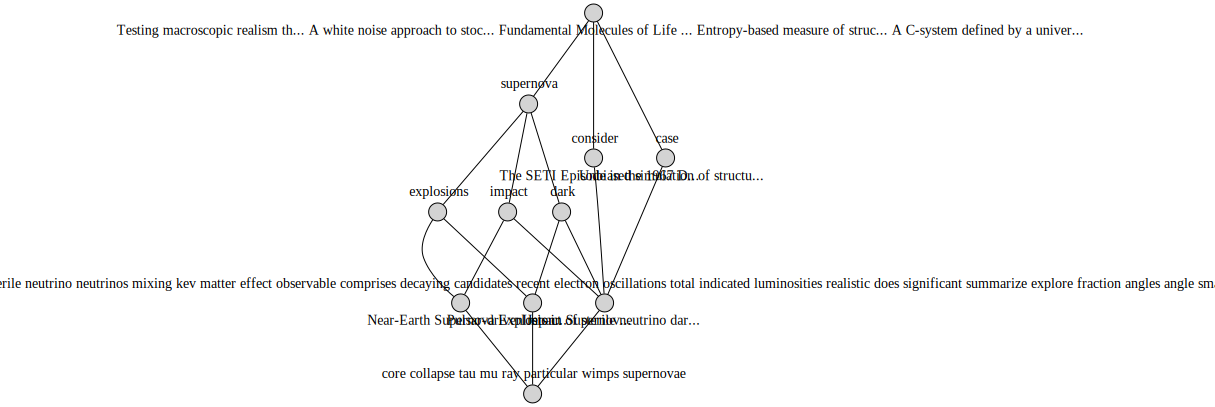

In [32]:
objects, properties, context = get_context(df, max_objects_count=10, max_properties_count=40)
d = {'objects': objects,
     'properties': properties,
     'context': context}
context = Context.fromdict(d)
context.lattice.graphviz()

In [33]:
context.objects

('Pulsar-driven Jets in Supernov...',
 'Testing macroscopic realism th...',
 'The SETI Episode in the 1967 D...',
 'A white noise approach to stoc...',
 'Fundamental Molecules of Life ...',
 'Entropy-based measure of struc...',
 'A C-system defined by a univer...',
 'Near-Earth Supernova Explosion...',
 'Unbiased simulation of structu...',
 'Impact of sterile neutrino dar...')

In [34]:
context.properties

('sterile',
 'neutrino',
 'neutrinos',
 'mixing',
 'dark',
 'kev',
 'core',
 'collapse',
 'matter',
 'supernova',
 'effect',
 'observable',
 'comprises',
 'tau',
 'decaying',
 'mu',
 'impact',
 'consider',
 'case',
 'explosions',
 'ray',
 'candidates',
 'recent',
 'electron',
 'oscillations',
 'total',
 'indicated',
 'luminosities',
 'particular',
 'realistic',
 'does',
 'significant',
 'summarize',
 'wimps',
 'explore',
 'supernovae',
 'fraction',
 'angles',
 'angle',
 'small')

In [37]:
context.intension(['Pulsar-driven Jets in Supernov...', 'Near-Earth Supernova Explosion...'])

('supernova', 'explosions')

In [38]:
context.extension(['supernova'])

('Pulsar-driven Jets in Supernov...',
 'Near-Earth Supernova Explosion...',
 'Impact of sterile neutrino dar...')

In [39]:
context.extension(['supernova', 'explosions'])

('Pulsar-driven Jets in Supernov...', 'Near-Earth Supernova Explosion...')

In [40]:
context == context.copy()

True